In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools
from cartopy.util import add_cyclic_point
from IPython.display import Image

## This notebook makes timeseries files of trophic levels of zooplankton

In [2]:
case = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.005'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/year_1'
variables = ['zoo1C','zoo2C','zoo3C','zoo4C','graze_diaz_zoo2','graze_cocco_zoo2',
             'graze_sp_zoo2','graze_zoo1_zoo2',
             'graze_diat_zoo3','graze_diaz_zoo3',
             'graze_cocco_zoo3','graze_zoo2_zoo3','graze_diat_zoo4','graze_zoo3_zoo4']
coords = {'x':'TLONG','y':'TLAT'}
keepthese = ['z_t','time_bound','TAREA','REGION_MASK', 'time'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']

In [3]:
%%time
ds_list = []
print(f'reading {case}')
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}/{case}.annual.{v}.????-????.nc'))       
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.005
zoo1C
zoo2C
zoo3C
zoo4C
graze_diaz_zoo2
graze_cocco_zoo2
graze_sp_zoo2
graze_zoo1_zoo2
graze_diat_zoo3
graze_diaz_zoo3
graze_cocco_zoo3
graze_zoo2_zoo3
graze_diat_zoo4
graze_zoo3_zoo4
CPU times: user 8.63 s, sys: 1.62 s, total: 10.2 s
Wall time: 12.6 s


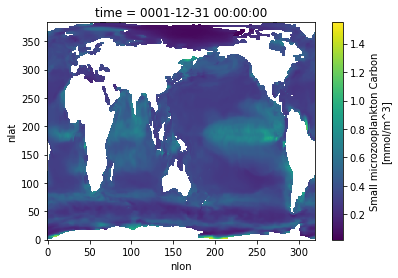

In [4]:
ds.zoo1C.isel(time=0,z_t_150m=0).plot() #.where(ds.REGION_MASK>0.).plot()

### plotting function

In [5]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### grab POP grid

In [6]:
grid = pop_tools.get_grid('POP_gx1v6')
lons = grid.TLONG
lats = grid.TLAT

In [7]:
years = np.arange(1958,2019,1)
years

array([1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018])

### make a trophic level 2 pop grid

In [8]:
## create Ft grid
TL2 = np.full((384, 320), 2, dtype=float)
TL2 = xr.DataArray(TL2)
TL2 = TL2.rename({'dim_0':'nlat',
                  'dim_1':'nlon'})

### zoo1 trophic level -- these are just herbivores so it's 2

In [9]:
zoo1_TL = TL2.where(grid.REGION_MASK>0.)

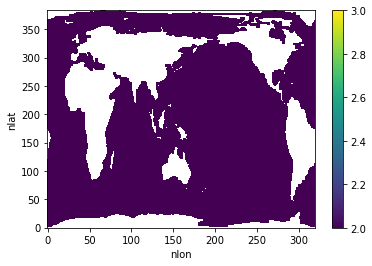

In [10]:
zoo1_TL.plot(vmin=2,vmax=3)

### do zoo2 grazing weighted trophic level for each depth level

In [11]:
graze_weight_TLsum = (ds.graze_diaz_zoo2 * 2. + ds.graze_cocco_zoo2 * 2. + ds.graze_sp_zoo2 * 2. + ds.graze_zoo1_zoo2 * (zoo1_TL + 1.))
graze_weight_sum = (ds.graze_diaz_zoo2 + ds.graze_cocco_zoo2 + ds.graze_sp_zoo2 + ds.graze_zoo1_zoo2)

zoo2_TL = graze_weight_TLsum / graze_weight_sum

### now create biomass weighted TL for zoo2

In [12]:
biomass_weight_TLsum = (ds.zoo2C * zoo2_TL).sum(dim='z_t_150m')
biomass_weight_sum = ds.zoo2C.sum(dim='z_t_150m')

zoo2_TL_zavg = biomass_weight_TLsum/biomass_weight_sum

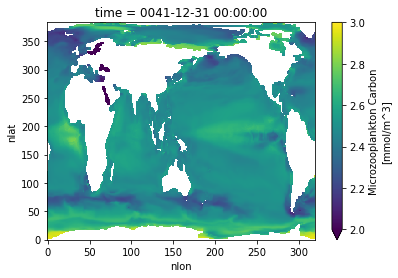

In [13]:
zoo2_TL_zavg.isel(time=40).plot(vmin=2,vmax=3)

### do zoo3 grazing weighted trophic level for each depth level

In [14]:
graze_weight_TLsum = (ds.graze_diaz_zoo3 * 2. + ds.graze_cocco_zoo3 * 2. + ds.graze_diat_zoo3 * 2. + ds.graze_zoo2_zoo3 * (zoo2_TL + 1.))
graze_weight_sum = (ds.graze_diaz_zoo3 + ds.graze_cocco_zoo3 + ds.graze_diat_zoo3 + ds.graze_zoo2_zoo3)

zoo3_TL = graze_weight_TLsum / graze_weight_sum

### now do biomass-weighted depth average for zoo3

In [15]:
biomass_weight_TLsum = (ds.zoo3C * zoo3_TL).sum(dim='z_t_150m')
biomass_weight_sum = ds.zoo3C.sum(dim='z_t_150m')

zoo3_TL_zavg = biomass_weight_TLsum/biomass_weight_sum

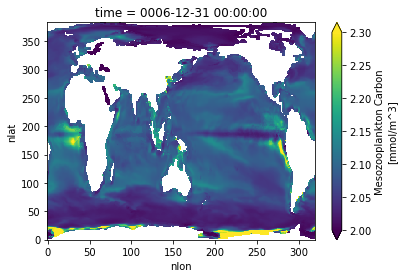

In [16]:
zoo3_TL_zavg.isel(time=5).plot(vmin=2,vmax=2.3)

### do zoo4 grazing weighted trophic level for each depth level

In [17]:
graze_weight_TLsum = (ds.graze_diat_zoo4 * 2. + ds.graze_zoo3_zoo4 * (zoo3_TL + 1.))
graze_weight_sum = (ds.graze_diat_zoo4 + ds.graze_zoo3_zoo4)

zoo4_TL = graze_weight_TLsum / graze_weight_sum

### now biomass weighted depth average for zoo4 TL

In [18]:
biomass_weight_TLsum = (ds.zoo4C * zoo4_TL).sum(dim='z_t_150m')
biomass_weight_sum = ds.zoo4C.sum(dim='z_t_150m')

zoo4_TL_zavg = biomass_weight_TLsum/biomass_weight_sum

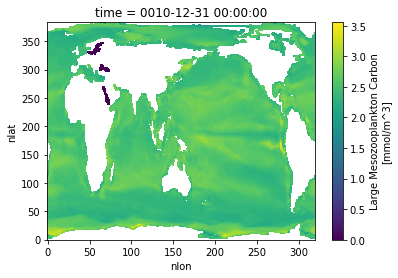

In [19]:
zoo4_TL_zavg.isel(time=9).plot()

### Make a set of maps for TL for each ZFT

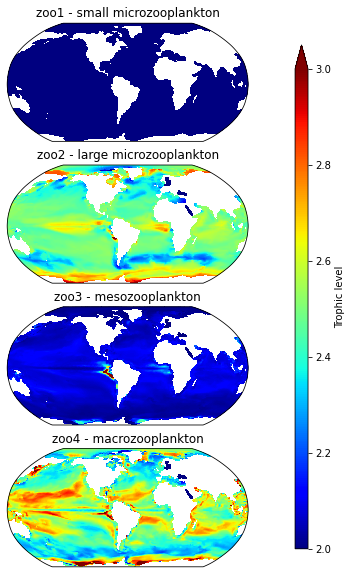

In [20]:
fig = plt.figure(figsize=(6,10))

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('zoo1 - small microzooplankton', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats, zoo1_TL)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=2,vmax=3,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('zoo2 - large microzooplankton', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats, zoo2_TL_zavg.isel(time=10))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=2,vmax=3,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('zoo3 - mesozooplankton', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats, zoo3_TL_zavg.isel(time=10))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=2,vmax=3,transform=ccrs.PlateCarree())

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('zoo4 - macrozooplankton', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats, zoo4_TL_zavg.isel(time=10))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=2,vmax=3,transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.colorbar(pc, extend='max', cax=cbar_ax, label='Trophic level');

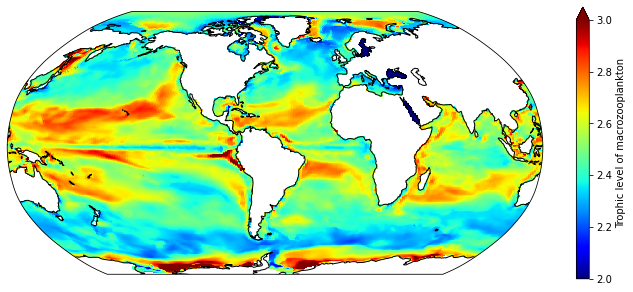

In [21]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
lon, lat, field = adjust_pop_grid(lons, lats, zoo4_TL_zavg.isel(time=10))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=2,vmax=3,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Trophic level of macrozooplankton')


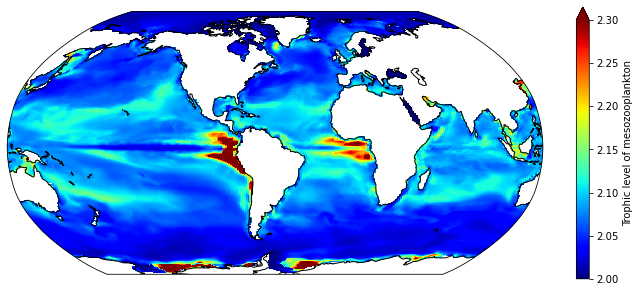

In [22]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
lon, lat, field = adjust_pop_grid(lons, lats, zoo3_TL_zavg.isel(time=10))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=2,vmax=2.3,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Trophic level of mesozooplankton')


### depth integrate biomass to use for weighting

In [22]:
tmp = ds.zoo1C * 10.
ds['zoo1C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo2C * 10.
ds['zoo2C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo3C * 10.
ds['zoo3C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo4C * 10.
ds['zoo4C_zint'] = tmp.sum(dim='z_t_150m')

### make a mean _microzooplankton_ TL and a mean  _large zooplankton_ TL

In [23]:
microzoo_TL = (zoo1_TL * ds.zoo1C_zint + zoo2_TL_zavg * ds.zoo2C_zint) / (ds.zoo1C_zint + ds.zoo2C_zint)

In [24]:
largezoo_TL = (zoo3_TL_zavg * ds.zoo3C_zint + zoo4_TL_zavg * ds.zoo4C_zint) / (ds.zoo3C_zint + ds.zoo4C_zint)

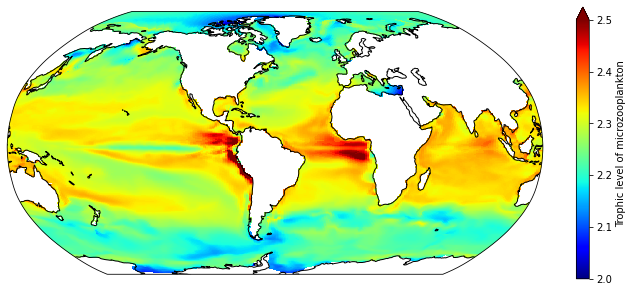

In [26]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
lon, lat, field = adjust_pop_grid(lons, lats, microzoo_TL.isel(time=10))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=2,vmax=2.5,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Trophic level of microzooplankton')


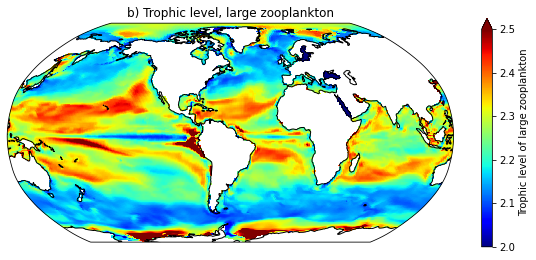

In [27]:
fig = plt.figure(figsize=(10,4.2))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
lon, lat, field = adjust_pop_grid(lons, lats, largezoo_TL.isel(time=10))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=2,vmax=2.5,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
ax.set_title('b) Trophic level, large zooplankton', fontsize=12)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Trophic level of large zooplankton')

#fig.savefig('/glade/u/home/kristenk/adding_zooplankton/MARBL_4p4z/images/TL_largezoo.png',dpi=300)

### Make mean trophic level for all zooplankton

In [25]:
zoo_TL = (zoo1_TL * ds.zoo1C_zint + zoo2_TL_zavg * ds.zoo2C_zint + zoo3_TL_zavg * ds.zoo3C_zint + zoo4_TL_zavg * ds.zoo4C_zint) / (ds.zoo1C_zint + ds.zoo2C_zint + ds.zoo3C_zint + ds.zoo4C_zint)

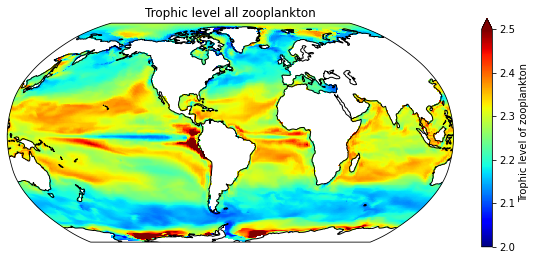

In [30]:
fig = plt.figure(figsize=(10,4.2))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
lon, lat, field = adjust_pop_grid(lons, lats, zoo_TL.isel(time=10))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=2,vmax=2.5,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
ax.set_title('Trophic level all zooplankton', fontsize=12)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Trophic level of zooplankton')

#fig.savefig('/glade/u/home/kristenk/adding_zooplankton/MARBL_4p4z/images/TL_allzoo.png',dpi=300)

### write out annual mean timeseries files

In [26]:
ds['zoo2_TL_zavg'] = zoo2_TL_zavg
ds.zoo2_TL_zavg.attrs['units'] = 'Trophic level'
ds.zoo2_TL_zavg.attrs['long_name'] = 'Trophic level of zoo2'

ds['zoo3_TL_zavg'] = zoo3_TL_zavg
ds.zoo3_TL_zavg.attrs['units'] = 'Trophic level'
ds.zoo3_TL_zavg.attrs['long_name'] = 'Trophic level of zoo3'

ds['zoo4_TL_zavg'] = zoo3_TL_zavg
ds.zoo4_TL_zavg.attrs['units'] = 'Trophic level'
ds.zoo4_TL_zavg.attrs['long_name'] = 'Trophic level of zoo4'

ds['microzoo_TL_zavg'] = microzoo_TL
ds.microzoo_TL_zavg.attrs['units'] = 'Trophic level'
ds.microzoo_TL_zavg.attrs['long_name'] = 'Mean trophic level of microzooplankton (zoo1 + zoo2)'

ds['largezoo_TL_zavg'] = largezoo_TL
ds.largezoo_TL_zavg.attrs['units'] = 'Trophic level'
ds.largezoo_TL_zavg.attrs['long_name'] = 'Mean trophic level of large zooplankton (zoo3 + zoo4)'

ds['all_zoo_TL_zavg'] = largezoo_TL
ds.all_zoo_TL_zavg.attrs['units'] = 'Trophic level'
ds.all_zoo_TL_zavg.attrs['long_name'] = 'Mean trophic level over all zooplankton types (zoo1 + zoo2 + zoo3 + zoo4)'

In [27]:
IAFy='0001-0061'
variables = ['zoo2_TL_zavg','zoo3_TL_zavg','zoo4_TL_zavg','microzoo_TL_zavg','largezoo_TL_zavg','all_zoo_TL_zavg']

In [34]:
# for v in variables:
    
#     print('writing ', v)
    
#     keep_vars = ['TLONG','TLAT', 'time', v]
    
#     ds_out = ds.drop([v for v in ds.variables if v not in keep_vars])
    
#     outfile='/glade/scratch/kristenk/archive/'+case+'/ocn/proc/tseries/year_1/'+case+'.annual.'+v+'.'+IAFy+'.nc'
#     ds_out.to_netcdf(outfile)

writing  zoo2_TL_zavg
writing  zoo3_TL_zavg
writing  zoo4_TL_zavg
writing  microzoo_TL_zavg
writing  largezoo_TL_zavg
writing  all_zoo_TL_zavg


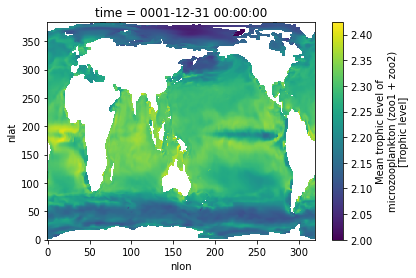

In [28]:
ds.microzoo_TL_zavg.isel(time=0).plot()

In [29]:
largezoo_stdev = ds.largezoo_TL_zavg.std(dim='time')

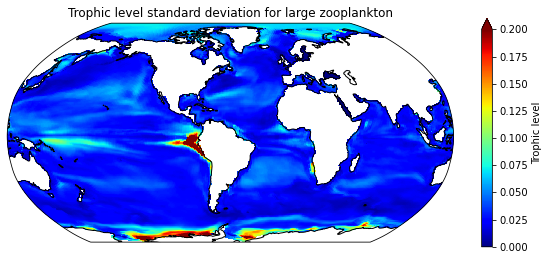

In [32]:
fig = plt.figure(figsize=(10,4.2))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
lon, lat, field = adjust_pop_grid(lons, lats, largezoo_stdev)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=0.2,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
ax.set_title('Trophic level standard deviation for large zooplankton', fontsize=12)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Trophic level')

#fig.savefig('/glade/u/home/kristenk/adding_zooplankton/MARBL_4p4z/images/TL_allzoo.png',dpi=300)

In [33]:
largezoo_coeff_variation = largezoo_stdev/ds.largezoo_TL_zavg.mean(dim='time')

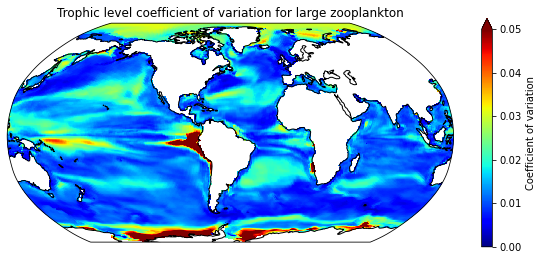

In [36]:
fig = plt.figure(figsize=(10,4.2))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
lon, lat, field = adjust_pop_grid(lons, lats, largezoo_coeff_variation)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=0.05, transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
ax.set_title('Trophic level coefficient of variation for large zooplankton', fontsize=12)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Coefficient of variation')

#fig.savefig('/glade/u/home/kristenk/adding_zooplankton/MARBL_4p4z/images/TL_allzoo.png',dpi=300)